In [1]:
import requests
import pandas as pd
import io
import tweepy
import json
import datetime
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Gather Data

In [2]:
#twitter archive
tweets = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#tweet image predictions
image_url = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv').content
image_raw = pd.read_csv(io.StringIO(image_url.decode('utf-8')),sep='\t', header=0)

In [4]:
#get all the identifiers to query twitter api
join = pd.merge(tweets, image_raw, on = 'tweet_id',how = 'outer')

In [5]:
identifiers = join['tweet_id'].values

In [6]:
with open('tweet_json.txt','r') as f:
    content = f.readlines()

In [7]:
data = {}
for item in content:
    d = json.loads(item)
    data[d['id']] = (d['retweet_count'],d['favorite_count'])

In [8]:
tdf = pd.DataFrame.from_dict(data,orient='index',columns=['retweets','likes'])
tdf['ID'] = tdf.index
tdf = tdf.reset_index(drop=True)

# Assess Data

In [9]:
## tweets visual

In [10]:
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
tweets['retweeted_status_id'].unique()

array([           nan, 8.87473957e+17, 8.86053734e+17, 8.30583321e+17,
       8.78057613e+17, 8.78281511e+17, 6.69000397e+17, 8.76850772e+17,
       8.66334965e+17, 8.68880398e+17, 8.73213776e+17, 8.72657584e+17,
       8.41077006e+17, 8.59196979e+17, 8.68552279e+17, 8.65013420e+17,
       8.66450706e+17, 8.37820168e+17, 8.63062472e+17, 8.06629075e+17,
       8.60563773e+17, 8.60914485e+17, 7.61672994e+17, 8.39549326e+17,
       8.57061112e+17, 8.44704788e+17, 8.56330159e+17, 8.42163533e+17,
       8.55122533e+17, 8.31650052e+17, 8.29374342e+17, 8.48289382e+17,
       8.33124695e+17, 8.32369877e+17, 8.47971000e+17, 7.56288534e+17,
       7.73308824e+17, 8.07106841e+17, 8.17423860e+17, 8.40632337e+17,
       6.67152164e+17, 8.39289919e+17, 8.38905981e+17, 7.83839966e+17,
       8.20749717e+17, 8.37011345e+17, 8.36648149e+17, 8.17827839e+17,
       7.86963064e+17, 8.35264099e+17, 7.53039831e+17, 8.29501995e+17,
       8.32434358e+17, 8.32766382e+17, 7.86709083e+17, 7.93286476e+17,
      

**Quality Issue #1 Some observations are retweets. If the tweet has a retweeted status id, it is a retweet and should be removed from the dataset.** 

In [12]:
tweets['in_reply_to_status_id'].unique()

array([           nan, 8.86266357e+17, 8.81607037e+17, 8.79553827e+17,
       8.70726203e+17, 8.63425646e+17, 6.67152164e+17, 8.57156678e+17,
       8.55818117e+17, 8.56286004e+17, 8.55861584e+17, 8.55858536e+17,
       8.50328819e+17, 8.48212112e+17, 8.47606176e+17, 7.59099524e+17,
       8.40698300e+17, 8.38145499e+17, 8.38085539e+17, 8.35245984e+17,
       8.32087548e+17, 8.31903044e+17, 8.26598365e+17, 8.23326389e+17,
       8.21152593e+17, 8.13127252e+17, 8.11627233e+17, 7.33109485e+17,
       8.01854331e+17, 8.00857954e+17, 7.97123751e+17, 7.72743019e+17,
       7.66711819e+17, 7.63865175e+17, 7.50180499e+17, 7.47648654e+17,
       7.46885919e+17, 6.91416866e+17, 7.38411920e+17, 7.29113531e+17,
       7.07980066e+17, 7.03255936e+17, 7.04485745e+17, 7.03041950e+17,
       6.96488711e+17, 6.75349384e+17, 6.70668383e+17, 6.93642232e+17,
       6.93572216e+17, 6.92417313e+17, 6.92041935e+17, 6.90341254e+17,
       6.86034025e+17, 6.85547936e+17, 6.84959799e+17, 6.84481075e+17,
      

**Quality Issue #2 Some observations are replies. Observations with a in_reply_to_status_id is a reply and should be omitted from the dataset.** 

In [13]:
## tweets programmatic

In [14]:
tweets.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [15]:
type(tweets['timestamp'][0])

str

**Quality Issue #3: Timestamp needs to be converted to a date time object in order to be manipulated**

In [16]:
tweets[['doggo','floofer','pupper','puppo']].head()

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None


**Tidy Issue #1 The dog type should be a single column**

**Quality Issue #4 Some dogs are listed as None for the above categories**

In [17]:
tweets['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [18]:
tweets['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

**Quality Issue #5 The denominators are not consistent**

In [19]:
tweets['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

**Quality Issue #6 The name variable has strange values such as "a" or "his" or "old". It is difficult to decifer if these are real names, typos, or whatnot**

In [20]:
tweets['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

**Quality Issue #7 The important information in the source variable is buried inside a url. This should be extracted for clean data**

In [21]:
## image visual

In [22]:
image_raw

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


**Quality Issue #8 Not all images are dogs** 

In [23]:
## image programmatic

In [24]:
image_raw.shape

(2075, 12)

In [25]:
image_raw.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [26]:
image_raw['p1'].nunique()

378

In [27]:
image_raw.groupby('p1').count()

,tweet_id,jpg_url,img_num,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
p1,,,,,,,,,,,
Afghan_hound,4,4,4,4,4,4,4,4,4,4,4
African_crocodile,1,1,1,1,1,1,1,1,1,1,1
African_grey,1,1,1,1,1,1,1,1,1,1,1
African_hunting_dog,1,1,1,1,1,1,1,1,1,1,1
Airedale,12,12,12,12,12,12,12,12,12,12,12
American_Staffordshire_terrier,13,13,13,13,13,13,13,13,13,13,13
American_black_bear,1,1,1,1,1,1,1,1,1,1,1
Angora,2,2,2,2,2,2,2,2,2,2,2
Appenzeller,2,2,2,2,2,2,2,2,2,2,2


In [28]:
## api visual

In [29]:
tdf.head()

,retweets,likes,ID
0,8194,37561,892420643555336193
1,6060,32288,892177421306343426
2,4008,24331,891815181378084864
3,8351,40914,891689557279858688
4,9044,39101,891327558926688256


**Tidy Issue #2: The name for the id column should be consistent across all three dataframes because they identify the same type of object**

In [30]:
## api programmatic

In [31]:
tdf.dtypes

retweets    int64
likes       int64
ID          int64
dtype: object

# Clean Data

In [32]:
#make copies of original data
tweets_original = tweets.copy()
images_original = image_raw.copy()
tdf_original = tdf.copy()

**Quality Issue #1**

In [33]:
#Define
#Some tweets are retweets
tweets['retweeted_status_id'].unique()

array([           nan, 8.87473957e+17, 8.86053734e+17, 8.30583321e+17,
       8.78057613e+17, 8.78281511e+17, 6.69000397e+17, 8.76850772e+17,
       8.66334965e+17, 8.68880398e+17, 8.73213776e+17, 8.72657584e+17,
       8.41077006e+17, 8.59196979e+17, 8.68552279e+17, 8.65013420e+17,
       8.66450706e+17, 8.37820168e+17, 8.63062472e+17, 8.06629075e+17,
       8.60563773e+17, 8.60914485e+17, 7.61672994e+17, 8.39549326e+17,
       8.57061112e+17, 8.44704788e+17, 8.56330159e+17, 8.42163533e+17,
       8.55122533e+17, 8.31650052e+17, 8.29374342e+17, 8.48289382e+17,
       8.33124695e+17, 8.32369877e+17, 8.47971000e+17, 7.56288534e+17,
       7.73308824e+17, 8.07106841e+17, 8.17423860e+17, 8.40632337e+17,
       6.67152164e+17, 8.39289919e+17, 8.38905981e+17, 7.83839966e+17,
       8.20749717e+17, 8.37011345e+17, 8.36648149e+17, 8.17827839e+17,
       7.86963064e+17, 8.35264099e+17, 7.53039831e+17, 8.29501995e+17,
       8.32434358e+17, 8.32766382e+17, 7.86709083e+17, 7.93286476e+17,
      

In [34]:
#Code
#remove retweets
tweets = tweets[pd.isnull(tweets['retweeted_status_id'])]

In [35]:
#Test
#verify that tweets with retweet status are removed
tweets.retweeted_status_id.unique() #only nan

array([nan])

In [36]:
#Code
#remove retweet columns
tweets = tweets.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

In [37]:
#verify that retweet columns are dropped
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Quality Issue #2**

In [38]:
#Define
#Some tweets are replies
tweets['in_reply_to_status_id'].unique()

array([           nan, 8.86266357e+17, 8.81607037e+17, 8.79553827e+17,
       8.70726203e+17, 8.63425646e+17, 6.67152164e+17, 8.57156678e+17,
       8.55818117e+17, 8.56286004e+17, 8.55861584e+17, 8.55858536e+17,
       8.50328819e+17, 8.48212112e+17, 8.47606176e+17, 7.59099524e+17,
       8.40698300e+17, 8.38145499e+17, 8.38085539e+17, 8.35245984e+17,
       8.32087548e+17, 8.31903044e+17, 8.26598365e+17, 8.23326389e+17,
       8.21152593e+17, 8.13127252e+17, 8.11627233e+17, 7.33109485e+17,
       8.01854331e+17, 8.00857954e+17, 7.97123751e+17, 7.72743019e+17,
       7.66711819e+17, 7.63865175e+17, 7.50180499e+17, 7.47648654e+17,
       7.46885919e+17, 6.91416866e+17, 7.38411920e+17, 7.29113531e+17,
       7.07980066e+17, 7.03255936e+17, 7.04485745e+17, 7.03041950e+17,
       6.96488711e+17, 6.75349384e+17, 6.70668383e+17, 6.93642232e+17,
       6.93572216e+17, 6.92417313e+17, 6.92041935e+17, 6.90341254e+17,
       6.86034025e+17, 6.85547936e+17, 6.84959799e+17, 6.84481075e+17,
      

In [39]:
#code
#remove tweets with reply status
tweets = tweets[pd.isnull(tweets['in_reply_to_status_id'])]

In [40]:
#test
#verify that replies are removed
tweets['in_reply_to_status_id'].unique()

array([nan])

In [41]:
#code
#drop reply columns
tweets = tweets.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)

In [42]:
tweets.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Quality Issue #3**

In [43]:
#Define
#time stamp is string but should be date time object
type(tweets['timestamp'][0])

str

In [44]:
#code
#convert to timestamp
tweets['timestamp'] = tweets['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S +0000'))

In [45]:
#test
type(tweets['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

**Tidy Issue #1**

In [46]:
#Define
#The dog type should be a column so the dummy variables need to be aggregated into a single column
tweets['doggo'].unique()
tweets['floofer'].unique()
tweets['pupper'].unique()
tweets['puppo'].unique()

array(['None', 'puppo'], dtype=object)

In [47]:
#code & test for tidy issue 1 is combined with quality issue 4

**Quality Issue #4**

In [48]:
#Define
#many dogs are not classified as a type ie doggo, floofer, etc
tweets[(tweets['doggo'] == 'None') & (tweets['floofer'] == 'None') & (tweets['pupper'] == 'None') & (tweets['puppo'] == 'None')].count()

tweet_id              1761
timestamp             1761
source                1761
text                  1761
expanded_urls         1759
rating_numerator      1761
rating_denominator    1761
name                  1761
doggo                 1761
floofer               1761
pupper                1761
puppo                 1761
dtype: int64

In [49]:
def f(row):
    val = 'None'
    count = 0
    if row['doggo'] == 'doggo':
        val = 'doggo'
        count +=1
    if row['floofer'] == 'floofer':
        val = 'floofer'
        count +=1
    if row['pupper'] == 'pupper':
        val = 'pupper'
        count +=1
    if row['puppo'] == 'puppo':
        val = 'puppo'
        count +=1
    if count > 1:
        val = 'multiple'
    if count == 0:
        val = 'not specified'
    return val

In [50]:
#Code for tidy issue 1 and quality issue 4
#Make a single column
tweets['type'] = tweets.apply(f, axis=1)

In [51]:
#drop other dummy variables
tweets = tweets.drop(['doggo','floofer','pupper','puppo'],axis=1)

In [52]:
#Test 
#anything that was none has been changed to not specified
tweets['type'].unique()

array(['not specified', 'doggo', 'puppo', 'pupper', 'floofer', 'multiple'],
      dtype=object)

**Quality Issue #5**

In [53]:
#Define
#The twitter denominator column does not have consistent values 
tweets.groupby('rating_denominator').count()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,type
rating_denominator,,,,,,,,
2,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
10,2080,2080,2080,2080,2077,2080,2080,2080
11,2,2,2,2,2,2,2,2
20,1,1,1,1,1,1,1,1
40,1,1,1,1,1,1,1,1
50,3,3,3,3,3,3,3,3
70,1,1,1,1,1,1,1,1
80,2,2,2,2,2,2,2,2


In [54]:
#Code
#since majority is 10, drop other values
tweets = tweets[tweets['rating_denominator']==10]

In [55]:
#test
tweets.groupby('rating_denominator').count() #shows that there are not denominators other than 10

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,type
rating_denominator,,,,,,,,
10,2080,2080,2080,2080,2077,2080,2080,2080


In [56]:
#Test
#display a few rows
tweets.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,type
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not specified
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified


**Quality Issue #6**

In [57]:
#Define
#Some dog names have weird values such as "a", "his", or "old"
tweets['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody',
       'Lassie', 'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble',
       'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper',
       'Harold', 'Shikha', 'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave',
    

In [58]:
#Code
#drop values that dont begin with a capital letter, aka a proper noun
tweets = tweets[tweets['name'].apply(lambda x: x[0].isupper())==True]

In [59]:
#test
#all nouns are proper, inproper nouns are dropped
tweets['name'].apply(lambda x: x[0].isupper()).unique()

array([ True])

**Quality Issue #7** 

In [60]:
#Define
#Source URL clunky. real information is embedded in URL
tweets['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [61]:
#code
def splitUrl(string):
    x = string.split('>')
    x = x[1].split('<')
    return x[0]

In [62]:
tweets['source'] = tweets['source'].apply(lambda x: splitUrl(x))

In [63]:
#Test
tweets['source'].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

**Quality issue #8**

In [64]:
#Define
#Not all the images are dogs.
image_raw[image_raw['p1_dog']==False]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,1.459380e-02,False,golden_retriever,7.958960e-03,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,2.784070e-01,True,groenendael,1.026430e-01,True
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,1.041090e-01,True,dingo,6.207120e-02,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,1.671750e-01,True,Chihuahua,8.695060e-02,True


In [65]:
#Code
#Keep observations where at least one prediction is a dog
image_raw = image_raw[(image_raw['p1_dog'] == True) | (image_raw['p2_dog'] == True) | (image_raw['p3_dog'] == True)]

In [66]:
#Test
#tweets without dogs were dropped
image_raw[(image_raw['p1_dog'] == False) & (image_raw['p2_dog'] == False) & (image_raw['p3_dog'] == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


**Tidy Issue #2**

In [67]:
#Define
#The id column should be named the same for each data table
tweets.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'type'],
      dtype='object')

In [68]:
tdf.columns

Index(['retweets', 'likes', 'ID'], dtype='object')

In [69]:
#code
tdf = tdf.rename(index=str,columns={'ID':'tweet_id'})

In [70]:
#test
tdf.columns

Index(['retweets', 'likes', 'tweet_id'], dtype='object')

## Merge Dataframes

In [71]:
archive = pd.merge(tweets, image_raw, on = 'tweet_id',how = 'inner')

In [72]:
archive = pd.merge(archive, tdf, on = 'tweet_id',how = 'inner')

In [73]:
archive.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,type,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6060,32288
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4008,24331
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8351,40914
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9044,39101
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,not specified,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,3003,19669


In [74]:
archive.to_csv('twitter_archive_master.csv',index=False)

# Analyze Data

In [75]:
archive.groupby(['source']).count() #iphone is the most popular source

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,type,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes
source,,,,,,,,,,,,,,,,,,,,,
TweetDeck,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Twitter Web Client,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Twitter for iPhone,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,...,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185


**Insight #1 The primary source for twitter is Twitter for iPhone.**

In [76]:
archive['rating_numerator'].mean()

11.148365465213747

**Insight #2 The average rating for dogs is 11.1 / 10.** 

In [77]:
archive.nlargest(1,'retweets')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,type,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes
352,807106840509214720,2016-12-09 06:17:20,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,not specified,https://pbs.twimg.com/ext_tw_video_thumb/80710...,...,0.50537,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,60188,125434


**Insight #3 Stephen the chihuahua is the most retweeted dog**

In [85]:
archive.nlargest(1,'likes')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,type,jpg_url,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes,intercept
269,822872901745569793,2017-01-21 18:26:02,Twitter for iPhone,Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,...,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,47058,138629,1


**Insight #4 A puppo lakeland terrier is the most "liked" dog.** 

In [79]:
archive['intercept']=1

In [80]:
archive.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,type,jpg_url,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes,intercept
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,True,Pekinese,0.090647,True,papillon,0.068957,True,6060,32288,1
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,True,malamute,0.078253,True,kelpie,0.031379,True,4008,24331,1
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8351,40914,1
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9044,39101,1
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,not specified,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,...,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,3003,19669,1


In [81]:
model = sm.OLS(archive['likes'],archive[['retweets','intercept','rating_numerator']]).fit()

In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     3830.
Date:                Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                        12:40:29   Log-Likelihood:                -11828.
No. Observations:                1193   AIC:                         2.366e+04
Df Residuals:                    1190   BIC:                         2.368e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
retweets             2.6639      0.032     83.310      0.000       2.601       2.727
intercept        -1952.4419    625.962     -3.119      0.002   -3180.553    -724.330
rating_numerator   404.8114     55.995      7.229      0.000     294.951     514.672
==============================================================================
Omnibus:                      212.545   Durbin-Watson:                   0.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4060.864
Skew:                           0.165   Prob(JB):                         0.00
Kurtosis:                      12.032   Cond. No.                     2.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Insight #5 For each additional retweet, likes increase by 2.66. For each unit change in rating numerator, likes increase by 404.** 

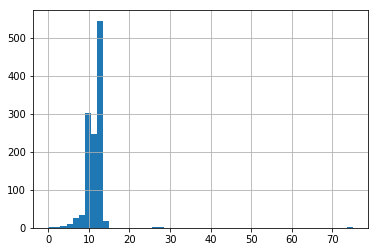

In [83]:
archive['rating_numerator'].hist(bins=50)

Visualization #1

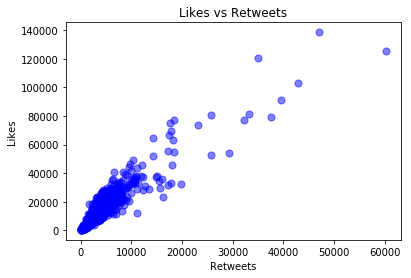

In [84]:
plt.scatter(archive['retweets'], archive['likes'], s=50, c='blue', alpha=0.5)
plt.title('Likes vs Retweets')
plt.xlabel('Retweets')
plt.ylabel('Likes')
plt.show()